In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


In [17]:
# Load Excel file
file_path = 'C:/Users/Admin/Desktop/DROUGHT-FORECASTING-IN-KENYA-USING-MACHINE-LEARNING/MLFile - Copy.xlsx'  # Replace with actual path
sheet_names = pd.ExcelFile(file_path).sheet_names
sheet_dict = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheet_names}
df.head()


,YEAR,WAJIR,IE,IW,N34,N4
0,1979,-0.311120,-0.2313,-0.2844,0.231,-0.175
1,1980,-0.680151,0.2668,-0.6530,-0.238,-0.145
2,1981,-0.541398,0.0457,-0.6259,-0.267,-0.376
3,1982,0.810631,-0.5488,0.4647,1.726,0.480
4,1983,-0.690986,0.0883,-0.1895,-0.866,-0.859


In [18]:
filtered_sheet_dict = {}
correlation_dict = {}  # To store correlation values for later use

for station, df in sheet_dict.items():
    print(f"\nProcessing station: {station}")
    print(f"Original columns: {df.columns.tolist()}")
    
    df_copy = df.copy()
    
    df_copy.dropna(inplace=True)
    

    if df_copy.empty:
        print(f"No data left for {station} after dropping missing values. Skipping...")
        continue
    

    year_col = "YEAR"
    rainfall_col = station  
    
    print(f"Year column: {year_col}")
    print(f"Rainfall column: {rainfall_col}")
    
    sst_cols = [col for col in df_copy.columns if col not in [year_col, rainfall_col]]
    print(f"SST columns: {sst_cols}")
    
    print(f"\nCorrelation results for {station}:")
    
    retained_cols = []
    station_correlations = {}  # Store correlations for this station
    
    for col in sst_cols:
        try:
            corr, p_value = stats.pearsonr(df_copy[col], df_copy[rainfall_col])
            print(f"{col}: r={corr:.2f}, p={p_value:.3f}")
            station_correlations[col] = {'correlation': corr, 'p_value': p_value}  # Save correlation stats
            
            if p_value <= 0.1:
                retained_cols.append(col)
            else:
                print(f"Dropped {col} from {station} (p={p_value:.3f})")
        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")
    
    correlation_dict[station] = station_correlations
    
    print(f"Retained {len(retained_cols)} predictors out of {len(sst_cols)} original variables")
    
    if not retained_cols:
        print(f"No significant predictors found for {station}. Skipping this station...")
        continue
    
    # Keep only YEAR, the rainfall column, and significant SST predictors
    filtered_df = df_copy[[year_col, rainfall_col] + retained_cols]
    filtered_sheet_dict[station] = filtered_df
    
    print(f"Final data for {station}:")
    display(filtered_df.head())
    print(f"Shape: {filtered_df.shape} (rows, columns)")
    print(f"Columns: {filtered_df.columns.tolist()}")
    print("-" * 60)


Processing station: WAJIR
Original columns: ['YEAR', 'WAJIR', 'IE', 'IW', 'N34', 'N4']
Year column: YEAR
Rainfall column: WAJIR
SST columns: ['IE', 'IW', 'N34', 'N4']

Correlation results for WAJIR:
IE: r=-0.39, p=0.008
IW: r=0.55, p=0.000
N34: r=0.44, p=0.002
N4: r=0.35, p=0.016
Retained 4 predictors out of 4 original variables
Final data for WAJIR:


,YEAR,WAJIR,IE,IW,N34,N4
0,1979,-0.311120,-0.2313,-0.2844,0.231,-0.175
1,1980,-0.680151,0.2668,-0.6530,-0.238,-0.145
2,1981,-0.541398,0.0457,-0.6259,-0.267,-0.376
3,1982,0.810631,-0.5488,0.4647,1.726,0.480
4,1983,-0.690986,0.0883,-0.1895,-0.866,-0.859


Shape: (46, 6) (rows, columns)
Columns: ['YEAR', 'WAJIR', 'IE', 'IW', 'N34', 'N4']
------------------------------------------------------------

Processing station: GARISSA
Original columns: ['YEAR', 'IE', 'IW', 'N34', 'N4', 'GARISSA']
Year column: YEAR
Rainfall column: GARISSA
SST columns: ['IE', 'IW', 'N34', 'N4']

Correlation results for GARISSA:
IE: r=-0.50, p=0.000
IW: r=0.52, p=0.000
N34: r=0.39, p=0.007
N4: r=0.28, p=0.058
Retained 4 predictors out of 4 original variables
Final data for GARISSA:


,YEAR,GARISSA,IE,IW,N34,N4
0,1979,-0.200977,-0.2313,-0.2844,0.231,-0.175
1,1980,-1.180739,0.2668,-0.6530,-0.238,-0.145
2,1981,-0.894839,0.0457,-0.6259,-0.267,-0.376
3,1982,0.522376,-0.5488,0.4647,1.726,0.480
4,1983,-1.263479,0.0883,-0.1895,-0.866,-0.859


Shape: (45, 6) (rows, columns)
Columns: ['YEAR', 'GARISSA', 'IE', 'IW', 'N34', 'N4']
------------------------------------------------------------

Processing station: LAMU
Original columns: ['YEAR', 'IE', 'IW', 'N34', 'N4', 'LAMU']
Year column: YEAR
Rainfall column: LAMU
SST columns: ['IE', 'IW', 'N34', 'N4']

Correlation results for LAMU:
IE: r=-0.42, p=0.004
IW: r=0.58, p=0.000
N34: r=0.49, p=0.001
N4: r=0.45, p=0.002
Retained 4 predictors out of 4 original variables
Final data for LAMU:


,YEAR,LAMU,IE,IW,N34,N4
0,1979,-1.224511,-0.2313,-0.2844,0.231,-0.175
1,1980,-0.740031,0.2668,-0.6530,-0.238,-0.145
2,1981,-0.510396,0.0457,-0.6259,-0.267,-0.376
3,1982,-0.228696,-0.5488,0.4647,1.726,0.480
4,1983,-1.161484,0.0883,-0.1895,-0.866,-0.859


Shape: (45, 6) (rows, columns)
Columns: ['YEAR', 'LAMU', 'IE', 'IW', 'N34', 'N4']
------------------------------------------------------------

Processing station: LODWAR
Original columns: ['YEAR', 'IE', 'IW', 'N34', 'N4', 'LODWAR']
Year column: YEAR
Rainfall column: LODWAR
SST columns: ['IE', 'IW', 'N34', 'N4']

Correlation results for LODWAR:
IE: r=-0.54, p=0.000
IW: r=0.61, p=0.000
N34: r=0.43, p=0.003
N4: r=0.36, p=0.015
Retained 4 predictors out of 4 original variables
Final data for LODWAR:


,YEAR,LODWAR,IE,IW,N34,N4
0,1979,-0.249406,-0.2313,-0.2844,0.231,-0.175
1,1980,-0.562060,0.2668,-0.6530,-0.238,-0.145
2,1981,-0.898634,0.0457,-0.6259,-0.267,-0.376
3,1982,3.206877,-0.5488,0.4647,1.726,0.480
4,1983,-0.550101,0.0883,-0.1895,-0.866,-0.859


Shape: (45, 6) (rows, columns)
Columns: ['YEAR', 'LODWAR', 'IE', 'IW', 'N34', 'N4']
------------------------------------------------------------

Processing station: MOMBASA
Original columns: ['YEAR', 'IE', 'IW', 'N34', 'N4', 'MOMBASA']
Year column: YEAR
Rainfall column: MOMBASA
SST columns: ['IE', 'IW', 'N34', 'N4']

Correlation results for MOMBASA:
IE: r=-0.53, p=0.000
IW: r=0.67, p=0.000
N34: r=0.53, p=0.000
N4: r=0.48, p=0.001
Retained 4 predictors out of 4 original variables
Final data for MOMBASA:


,YEAR,MOMBASA,IE,IW,N34,N4
0,1979,-0.530462,-0.2313,-0.2844,0.231,-0.175
1,1980,-0.734569,0.2668,-0.6530,-0.238,-0.145
2,1981,0.202190,0.0457,-0.6259,-0.267,-0.376
3,1982,0.006516,-0.5488,0.4647,1.726,0.480
4,1983,-0.768494,0.0883,-0.1895,-0.866,-0.859


Shape: (45, 6) (rows, columns)
Columns: ['YEAR', 'MOMBASA', 'IE', 'IW', 'N34', 'N4']
------------------------------------------------------------

Processing station: MOYALE
Original columns: ['YEAR', 'IE', 'IW', 'N34', 'N4', 'MOYALE']
Year column: YEAR
Rainfall column: MOYALE
SST columns: ['IE', 'IW', 'N34', 'N4']

Correlation results for MOYALE:
IE: r=-0.62, p=0.000
IW: r=0.66, p=0.000
N34: r=0.46, p=0.001
N4: r=0.40, p=0.006
Retained 4 predictors out of 4 original variables
Final data for MOYALE:


,YEAR,MOYALE,IE,IW,N34,N4
0,1979,0.062640,-0.2313,-0.2844,0.231,-0.175
1,1980,-0.554230,0.2668,-0.6530,-0.238,-0.145
2,1981,-0.396922,0.0457,-0.6259,-0.267,-0.376
3,1982,0.293028,-0.5488,0.4647,1.726,0.480
4,1983,-0.947159,0.0883,-0.1895,-0.866,-0.859


Shape: (45, 6) (rows, columns)
Columns: ['YEAR', 'MOYALE', 'IE', 'IW', 'N34', 'N4']
------------------------------------------------------------

Processing station: VOI
Original columns: ['YEAR', 'IE', 'IW', 'N34', 'N4', 'VOI']
Year column: YEAR
Rainfall column: VOI
SST columns: ['IE', 'IW', 'N34', 'N4']

Correlation results for VOI:
IE: r=-0.43, p=0.003
IW: r=0.35, p=0.019
N34: r=0.29, p=0.050
N4: r=0.26, p=0.089
Retained 4 predictors out of 4 original variables
Final data for VOI:


,YEAR,VOI,IE,IW,N34,N4
0,1979,0.113305,-0.2313,-0.2844,0.231,-0.175
1,1980,-0.641006,0.2668,-0.6530,-0.238,-0.145
2,1981,0.386318,0.0457,-0.6259,-0.267,-0.376
3,1982,0.935584,-0.5488,0.4647,1.726,0.480
4,1983,-1.489939,0.0883,-0.1895,-0.866,-0.859


Shape: (45, 6) (rows, columns)
Columns: ['YEAR', 'VOI', 'IE', 'IW', 'N34', 'N4']
------------------------------------------------------------



Results for WAJIR using Random Forest:
  R² = -0.427
  RMSE = 0.962
  MAE = 0.736


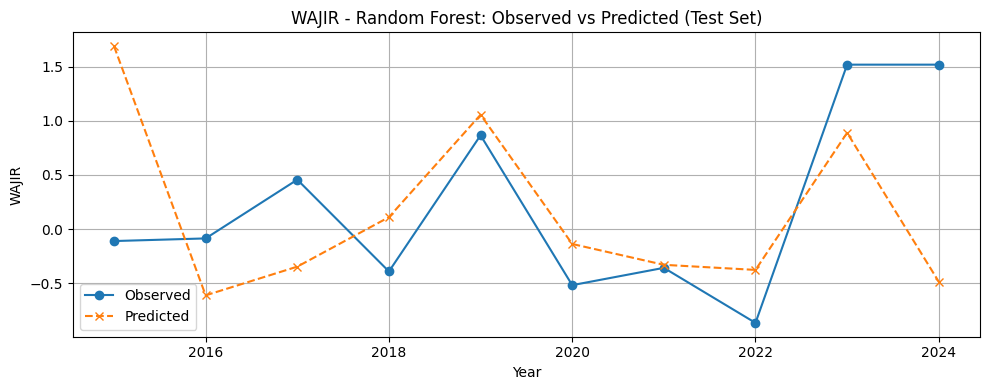


Results for WAJIR using Gradient Boosting:
  R² = -1.499
  RMSE = 1.273
  MAE = 0.897


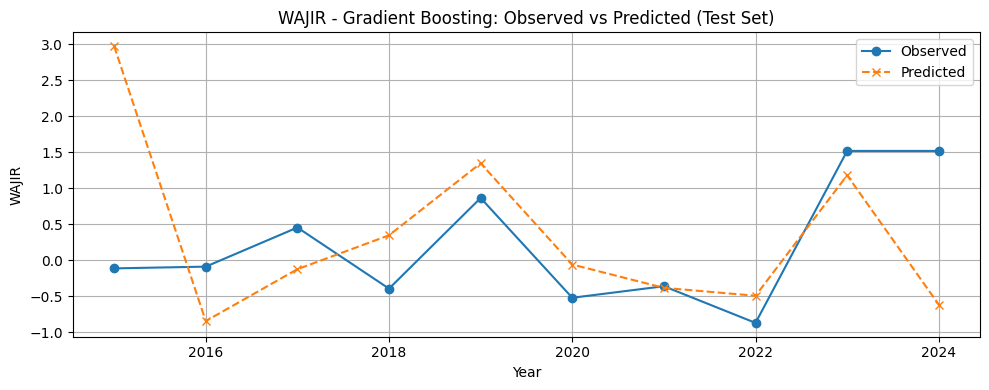


Results for WAJIR using SVR:
  R² = -0.002
  RMSE = 0.806
  MAE = 0.615


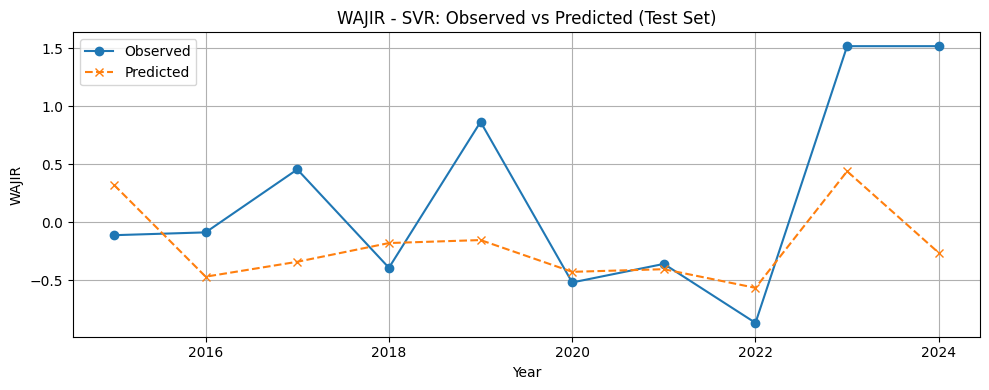


Results for WAJIR using Neural Network:
  R² = 0.311
  RMSE = 0.669
  MAE = 0.493


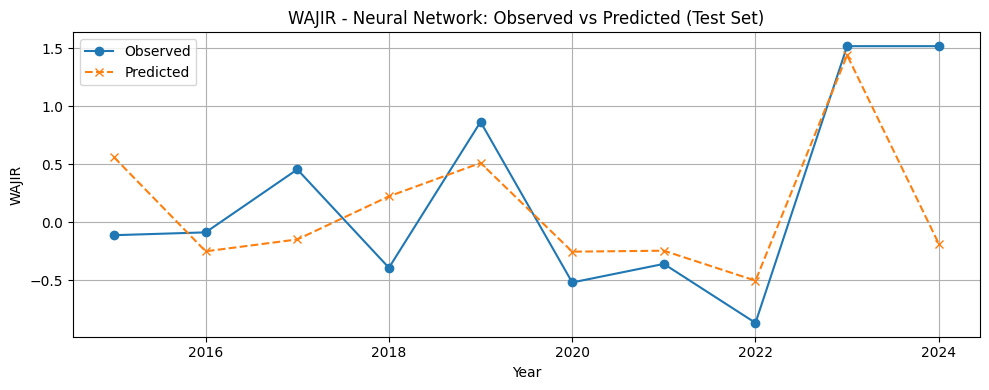


Results for GARISSA using Random Forest:
  R² = 0.438
  RMSE = 0.837
  MAE = 0.722


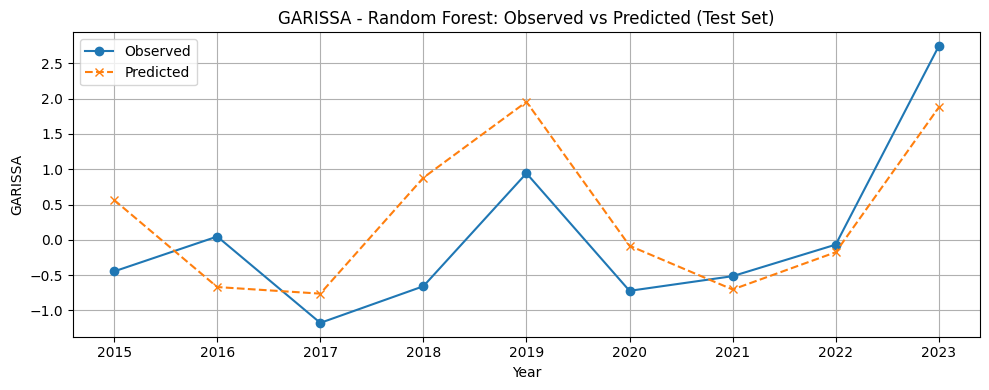


Results for GARISSA using Gradient Boosting:
  R² = 0.033
  RMSE = 1.098
  MAE = 0.809


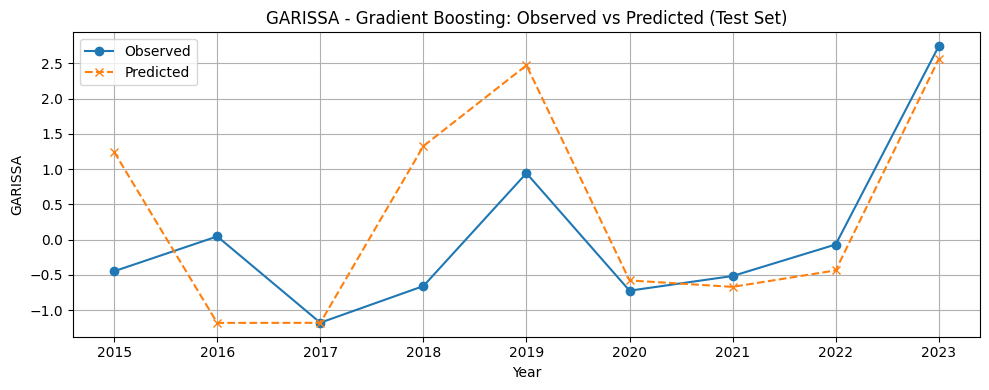


Results for GARISSA using SVR:
  R² = 0.250
  RMSE = 0.967
  MAE = 0.762


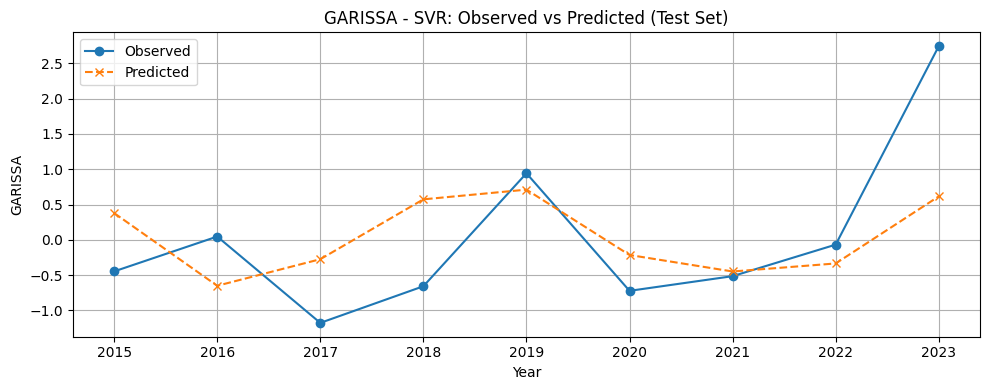


Results for GARISSA using Neural Network:
  R² = 0.380
  RMSE = 0.879
  MAE = 0.664


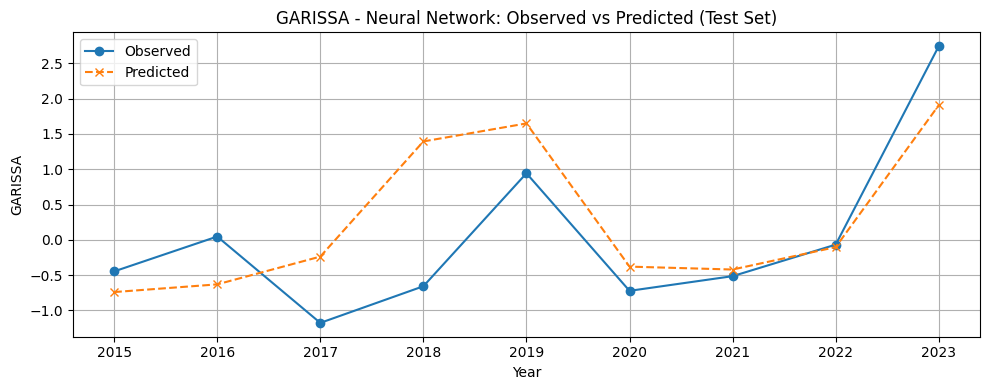


Results for LAMU using Random Forest:
  R² = 0.433
  RMSE = 0.763
  MAE = 0.611


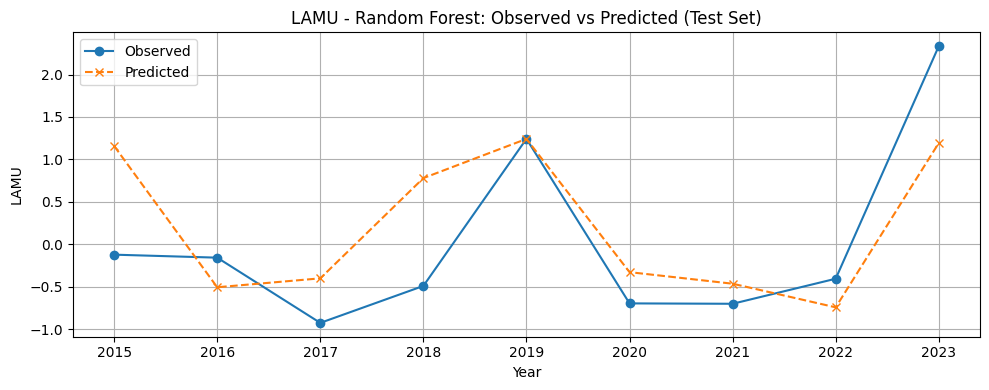


Results for LAMU using Gradient Boosting:
  R² = 0.153
  RMSE = 0.933
  MAE = 0.775


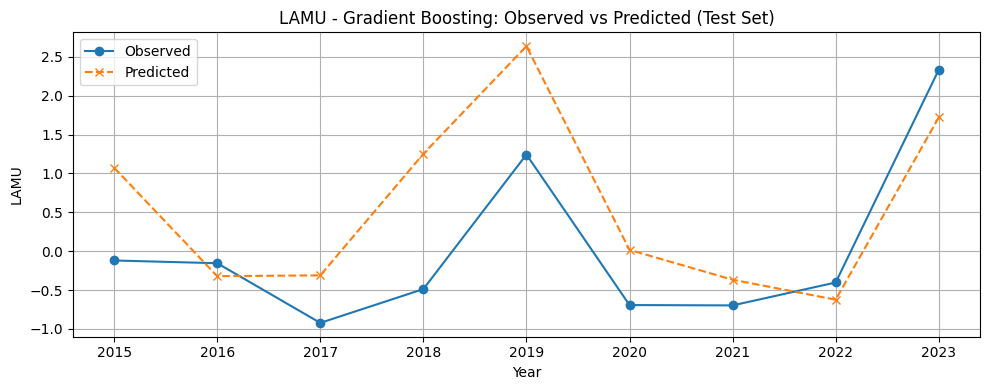


Results for LAMU using SVR:
  R² = 0.211
  RMSE = 0.900
  MAE = 0.628


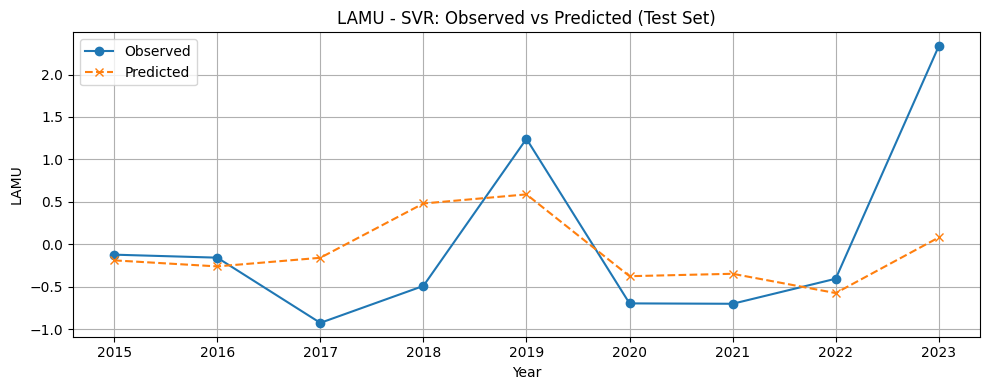


Results for LAMU using Neural Network:
  R² = -1.134
  RMSE = 1.481
  MAE = 1.181


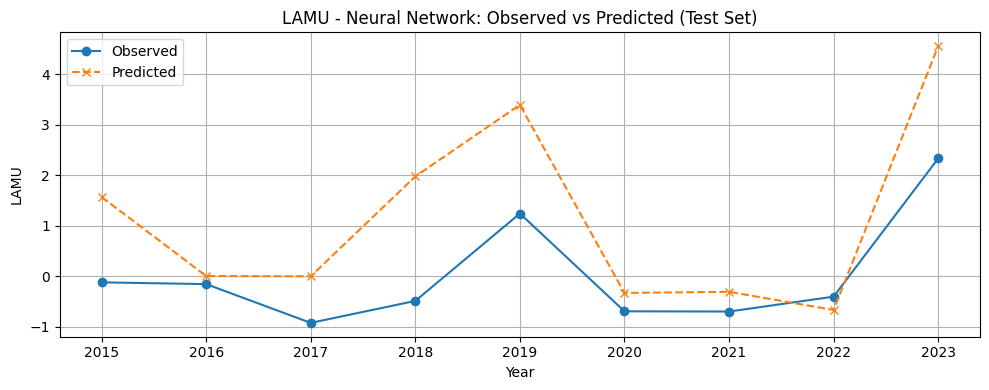


Results for LODWAR using Random Forest:
  R² = -0.082
  RMSE = 0.863
  MAE = 0.768


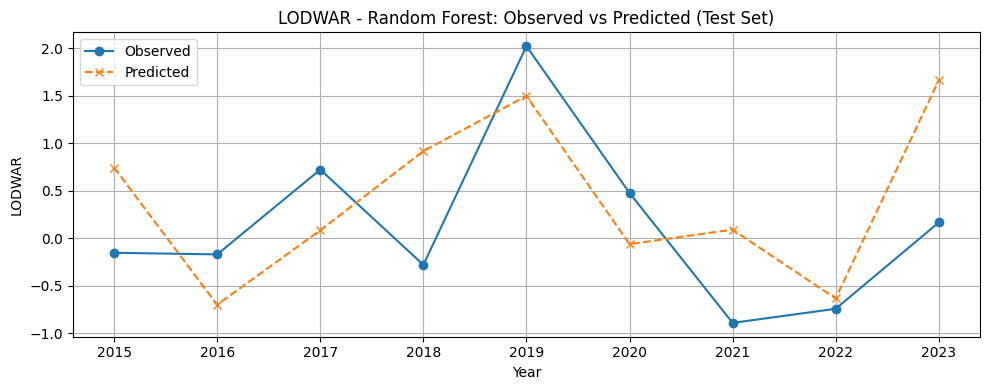


Results for LODWAR using Gradient Boosting:
  R² = 0.236
  RMSE = 0.726
  MAE = 0.644


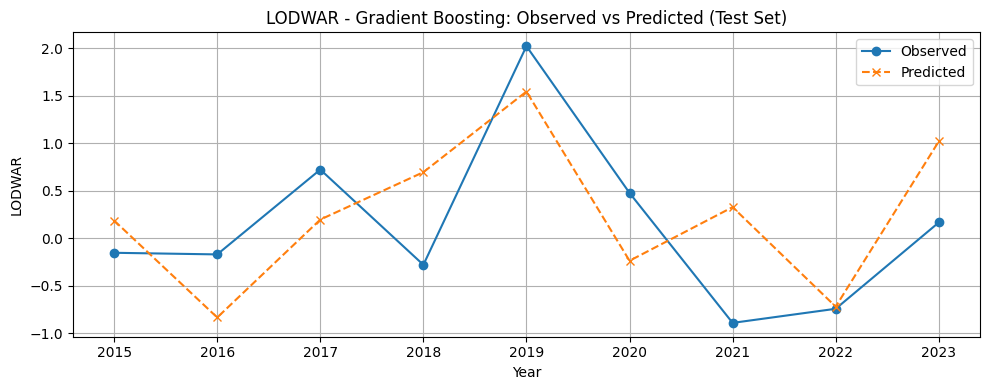


Results for LODWAR using SVR:
  R² = -0.102
  RMSE = 0.871
  MAE = 0.682


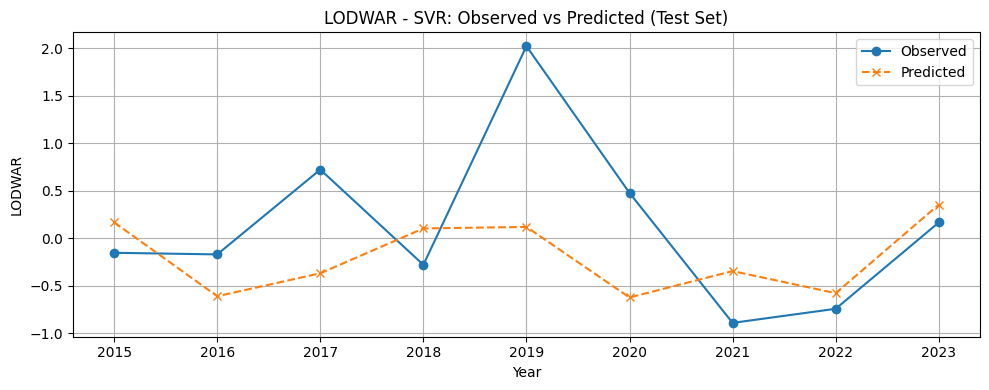


Results for LODWAR using Neural Network:
  R² = -0.771
  RMSE = 1.104
  MAE = 0.786


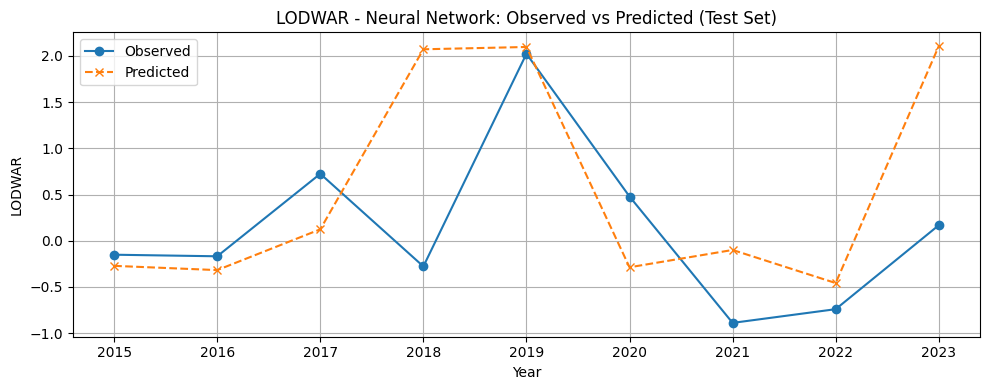


Results for MOMBASA using Random Forest:
  R² = 0.796
  RMSE = 0.477
  MAE = 0.327


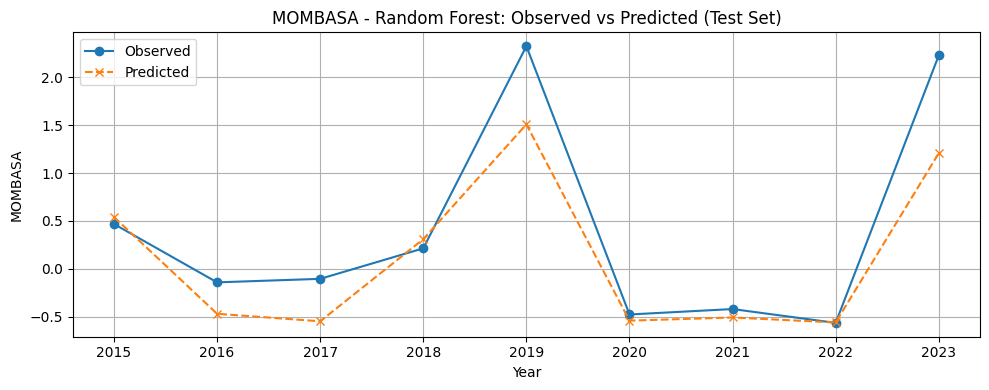


Results for MOMBASA using Gradient Boosting:
  R² = 0.775
  RMSE = 0.500
  MAE = 0.341


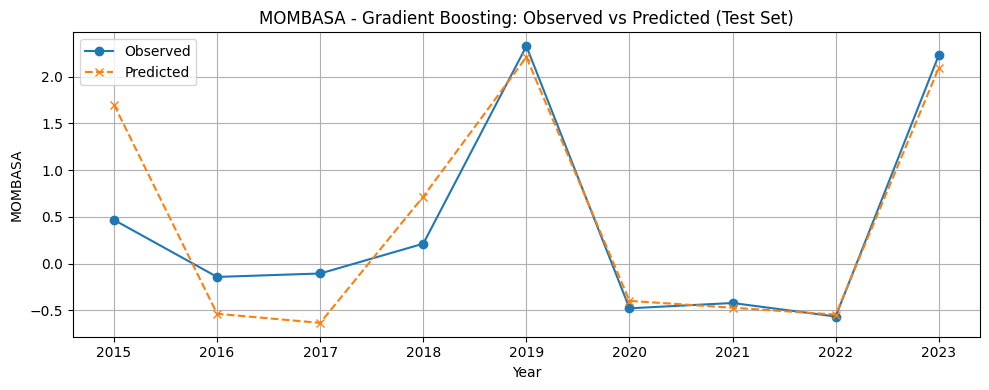


Results for MOMBASA using SVR:
  R² = 0.197
  RMSE = 0.946
  MAE = 0.603


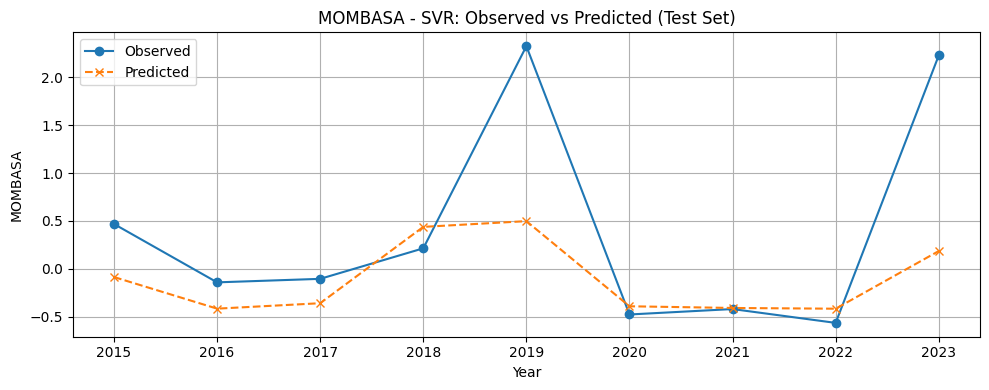


Results for MOMBASA using Neural Network:
  R² = 0.766
  RMSE = 0.510
  MAE = 0.333


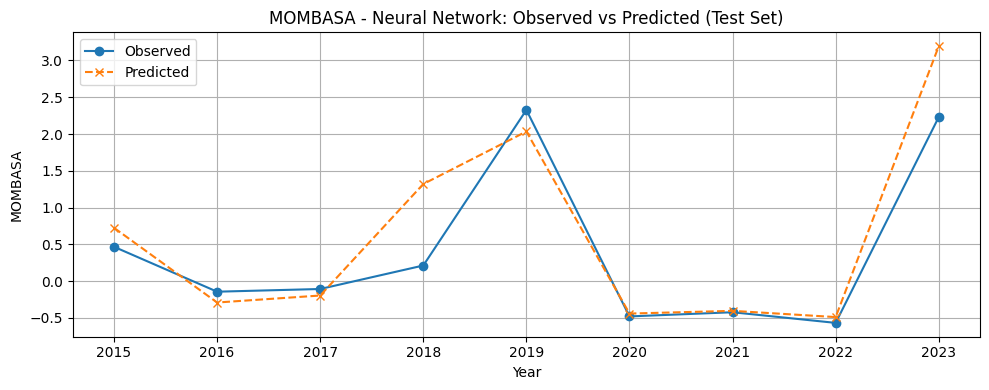


Results for MOYALE using Random Forest:
  R² = 0.625
  RMSE = 0.527
  MAE = 0.394


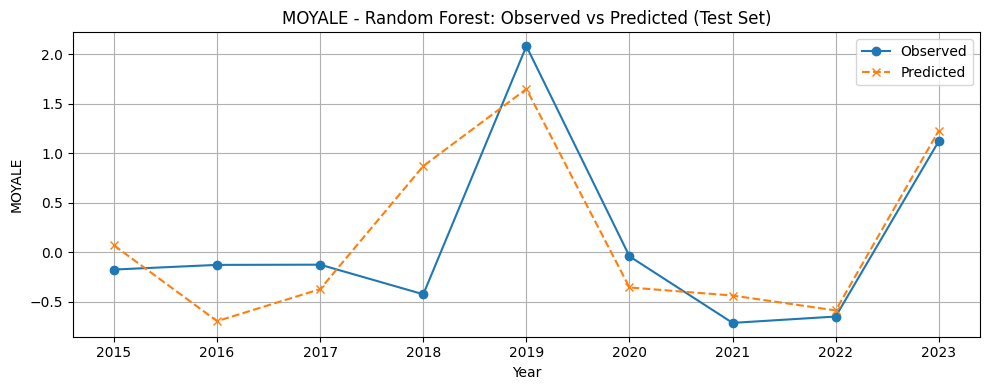


Results for MOYALE using Gradient Boosting:
  R² = -0.087
  RMSE = 0.898
  MAE = 0.630


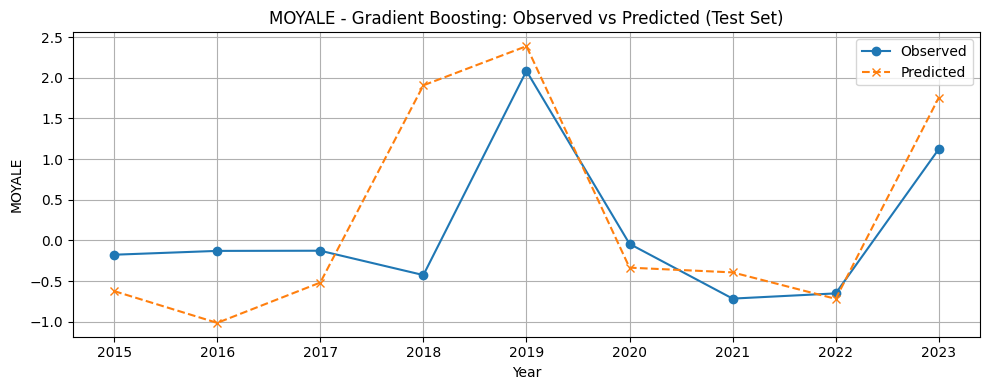


Results for MOYALE using SVR:
  R² = 0.300
  RMSE = 0.721
  MAE = 0.580


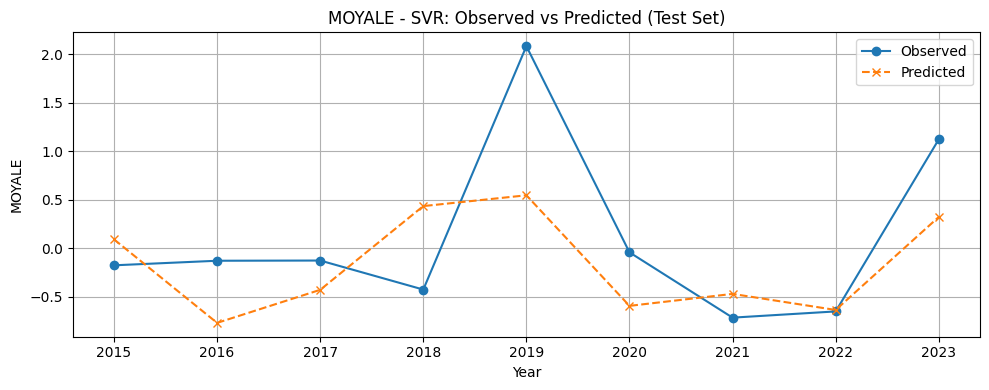


Results for MOYALE using Neural Network:
  R² = 0.343
  RMSE = 0.698
  MAE = 0.434


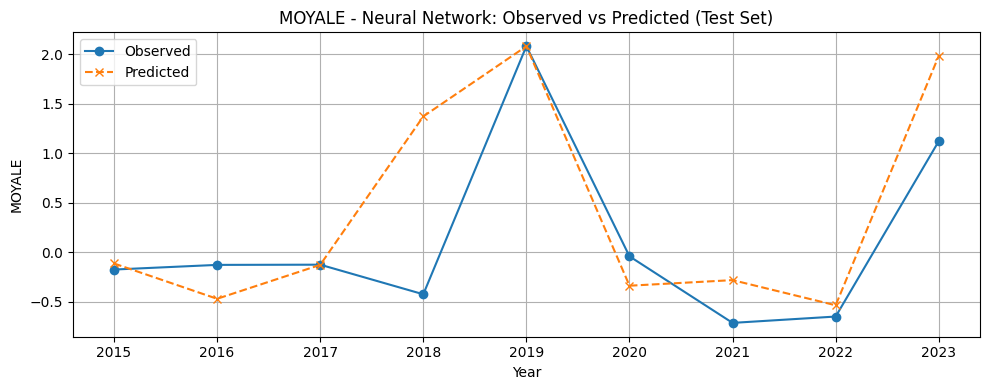


Results for VOI using Random Forest:
  R² = 0.111
  RMSE = 0.782
  MAE = 0.688


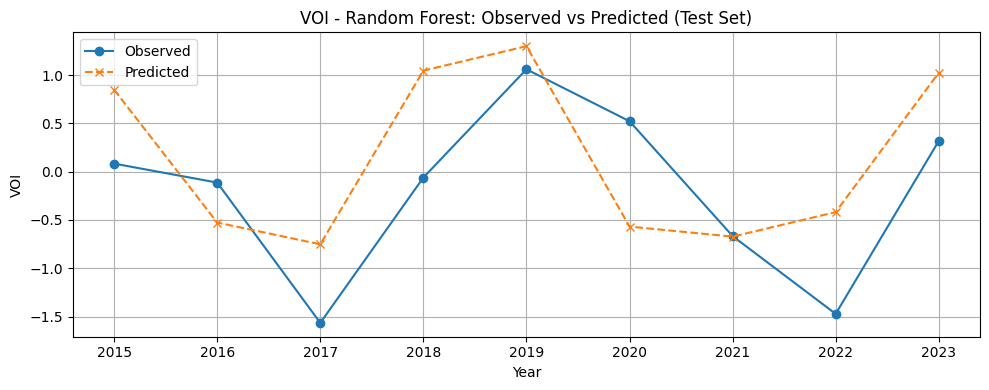


Results for VOI using Gradient Boosting:
  R² = -0.104
  RMSE = 0.871
  MAE = 0.740


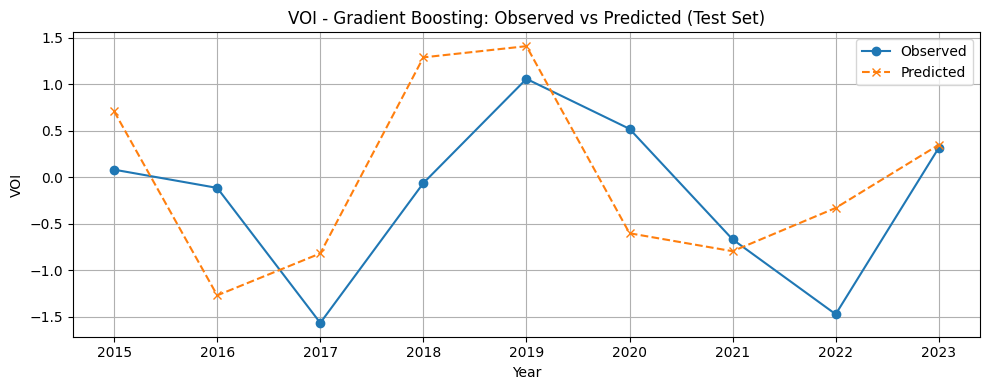


Results for VOI using SVR:
  R² = -0.082
  RMSE = 0.862
  MAE = 0.729


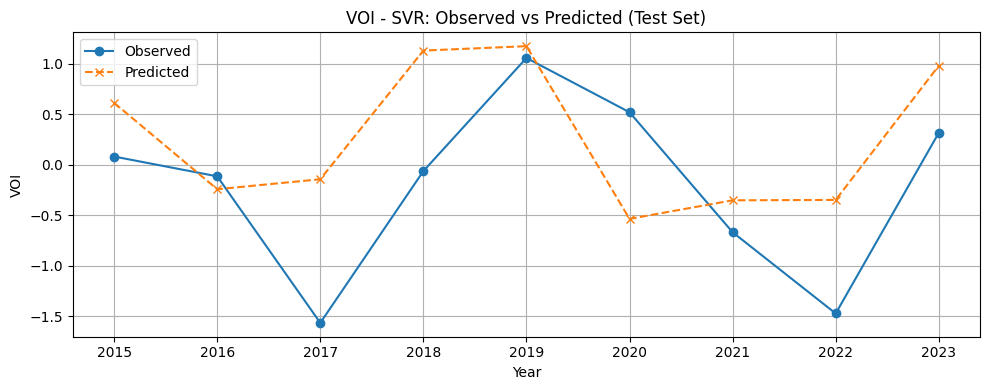


Results for VOI using Neural Network:
  R² = -1.153
  RMSE = 1.217
  MAE = 1.100


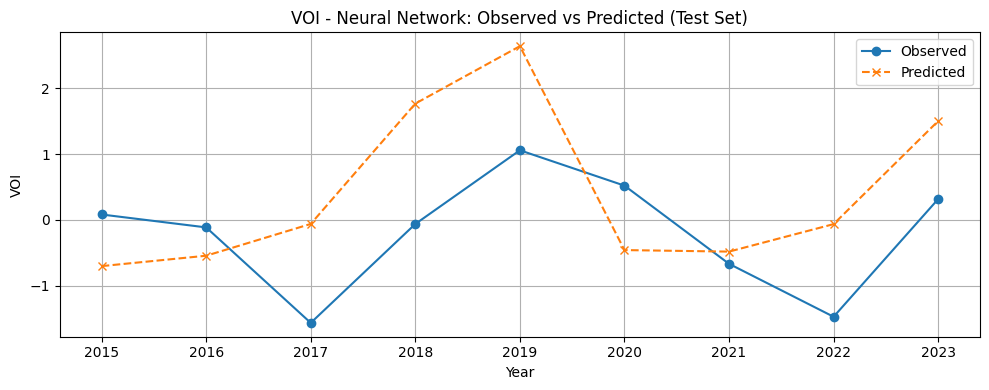

In [19]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

model_configs = [
    {"Station": station_name, "Model": model_type} 
    for station_name in filtered_sheet_dict.keys() 
    for model_type in ["Random Forest", "Gradient Boosting", "SVR", "Neural Network"]
]
model_df = pd.DataFrame(model_configs)

#result container
results_dict = {}

for _, row in model_df.iterrows():
    station = row["Station"]
    model_name = row["Model"]
    
    # Check if this station exists in filtered data
    if station not in filtered_sheet_dict:
        print(f"Station {station} not found in filtered data. Skipping...")
        continue
    
    df = filtered_sheet_dict[station].copy()
    target_col = df.columns[1]  # Assuming this is your rainfall column
    
    
    X = df.drop(columns=["YEAR", target_col])
    
    # Check if we have features to work with
    if X.shape[1] == 0:
        print(f"No features available for {station}. Skipping model creation.")
        continue
        
    y = df[target_col]
    years = df["YEAR"].values
    
    # Initialize the model
    if model_name == "Random Forest":
        model = RandomForestRegressor(n_estimators=100, random_state=0)
    elif model_name == "Gradient Boosting":
        model = GradientBoostingRegressor(n_estimators=100, random_state=0)
    elif model_name == "SVR":
        model = SVR()
    elif model_name == "Neural Network":
        model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=0)
    else:
        print(f"Unknown model type: {model_name}. Skipping...")
        continue
    
    # Check if we have enough data to split
    if len(X) < 5:  # Arbitrary small number, adjust as needed
        print(f"Not enough data points for {station}. Skipping model creation.")
        continue
    
    # Use last 20% for testing
    split_index = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    years_test = years[split_index:]
    
    # Fit the model
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Store results
        if station not in results_dict:
            results_dict[station] = {}
        results_dict[station][model_name] = {
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'predictions': y_pred,
            'actuals': y_test.values,
            'years': years_test
        }
        
    
        print(f"\nResults for {station} using {model_name}:")
        print(f"  R² = {r2:.3f}")
        print(f"  RMSE = {rmse:.3f}")
        print(f"  MAE = {mae:.3f}")
        
        
        plt.figure(figsize=(10, 4))
        plt.plot(years_test, y_test.values, label="Observed", marker='o')
        plt.plot(years_test, y_pred, label="Predicted", linestyle='--', marker='x')
        plt.title(f"{station} - {model_name}: Observed vs Predicted (Test Set)")
        plt.xlabel("Year")
        plt.ylabel(f"{target_col}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error training {model_name} for {station}: {str(e)}")